In [1]:
import json
import requests
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
import torch
import torch.nn as nn
import torch

In [2]:
df = pd.read_csv('preprocessing/crypto_data.csv')
coins = df['coin'].unique()

def train_test_split(df, test_val_size=0.15):
    train_data = pd.DataFrame(columns=df.columns)
    test_data = pd.DataFrame(columns=df.columns)
    for i, coin in enumerate(coins):
        df_
        df_coin = df.loc[df['coin'] == coin]
        split_row = len(df_coin) - int(test_val_size * len(df_coin))
    
        train_data = pd.concat([train_data, df_coin.iloc[:split_row]]) 
        test_data = pd.concat([test_data, df_coin.iloc[split_row:]])
        print(train_data.tail())
    
    # print(train_data.columns)
    mean_p = train_data['p'].mean()
    std_p = train_data['p'].std()
    train_data['p'] = (train_data['p']-mean_p)/std_p
    test_data['p'] = (test_data['p']-mean_p)/std_p
    

    return train_data, test_data
train, test = train_test_split(df, test_val_size=0.2)

            date          high           low          open         close  \
1427  1606867200  19308.330078  18347.718750  18801.744141  19201.091797   
1428  1606953600  19566.191406  18925.785156  19205.925781  19445.398438   
1429  1607040000  19511.404297  18697.193359  19446.966797  18699.765625   
1430  1607126400  19160.449219  18590.193359  18698.384766  19154.230469   
1431  1607212800  19390.500000  18897.894531  19154.179688  19345.121094   

            volume      adjclose     coin         p  
1427  3.738770e+10  19201.091797  BTC-USD  1.021240  
1428  3.193032e+10  19445.398438  BTC-USD  1.012469  
1429  3.387239e+10  18699.765625  BTC-USD  0.961577  
1430  2.724246e+10  19154.230469  BTC-USD  1.024379  
1431  2.529378e+10  19345.121094  BTC-USD  1.009969  
            date        high         low        open       close  \
3216  1606867200  604.022461  578.741028  587.261597  598.352356   
3217  1606953600  622.452698  588.346375  598.459229  616.708740   
3218  160704000

In [11]:
def extract_window_data(df, window_len):
    window_data = []
    
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        
        window_data.append(tmp.values)
    return np.array(window_data)

def prepare_data(df, target_col, window_len=10, test_val_size=0.15):
    train_data, val_data, test_data = train_test_split(df, test_val_size=test_val_size)
    # print(train_data.shape)
    X_train = extract_window_data(train_data, window_len)
    # print(X_train.shape)
    X_val = extract_window_data(val_data, window_len) 
    X_test = extract_window_data(test_data, window_len)
    
    y_train = train_data[target_col][window_len:].values
    y_train = val_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values

    #print(len(train_data[target_col][:-window_len].values-1))
    #print(len(y_train))
    
    # print(X_train, y_train)

    return train_data, val_data, test_data, X_train, X_test, y_train, y_test
train, val, test, X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(df, 'p', window_len=window_len, test_size=test_size)

            date          high           low          open         close  \
1427  1606867200  19308.330078  18347.718750  18801.744141  19201.091797   
1428  1606953600  19566.191406  18925.785156  19205.925781  19445.398438   
1429  1607040000  19511.404297  18697.193359  19446.966797  18699.765625   
1430  1607126400  19160.449219  18590.193359  18698.384766  19154.230469   
1431  1607212800  19390.500000  18897.894531  19154.179688  19345.121094   

            volume      adjclose     coin         p  
1427  3.738770e+10  19201.091797  BTC-USD  1.021240  
1428  3.193032e+10  19445.398438  BTC-USD  1.012469  
1429  3.387239e+10  18699.765625  BTC-USD  0.961577  
1430  2.724246e+10  19154.230469  BTC-USD  1.024379  
1431  2.529378e+10  19345.121094  BTC-USD  1.009969  
            date        high         low        open       close  \
3216  1606867200  604.022461  578.741028  587.261597  598.352356   
3217  1606953600  622.452698  588.346375  598.459229  616.708740   
3218  160704000

In [4]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear', dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [5]:
np.random.seed(42)
window_len = 5
test_size = 0.2
# zero_base = True
lstm_neurons = 100
epochs = 10
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [9]:
train, test, X_train, X_test, y_train, y_test = prepare_data(df, 'p', window_len=window_len, test_size=test_size)

X_train = X_train[:,:,:-3]


print(X_train.shape)


model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)

X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)


history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

            date          high           low          open         close  \
1427  1606867200  19308.330078  18347.718750  18801.744141  19201.091797   
1428  1606953600  19566.191406  18925.785156  19205.925781  19445.398438   
1429  1607040000  19511.404297  18697.193359  19446.966797  18699.765625   
1430  1607126400  19160.449219  18590.193359  18698.384766  19154.230469   
1431  1607212800  19390.500000  18897.894531  19154.179688  19345.121094   

            volume      adjclose     coin         p  
1427  3.738770e+10  19201.091797  BTC-USD  1.021240  
1428  3.193032e+10  19445.398438  BTC-USD  1.012469  
1429  3.387239e+10  18699.765625  BTC-USD  0.961577  
1430  2.724246e+10  19154.230469  BTC-USD  1.024379  
1431  2.529378e+10  19345.121094  BTC-USD  1.009969  
            date        high         low        open       close  \
3216  1606867200  604.022461  578.741028  587.261597  598.352356   
3217  1606953600  622.452698  588.346375  598.459229  616.708740   
3218  160704000

(18106, 5, 9)
18106
18106
[[[1483228800 1003.0800170898438 958.698974609375 ... 998.3250122070312
   'BTC-USD' 0.43816154594393686]
  [1483315200 1031.3900146484375 996.7020263671876 ... 1021.75 'BTC-USD'
   0.2595922965141888]
  [1483401600 1044.0799560546875 1021.5999755859376 ...
   1043.8399658203125 'BTC-USD' 0.24014147947062198]
  [1483488000 1159.4200439453125 1044.4000244140625 ... 1154.72998046875
   'BTC-USD' 1.409332615750027]
  [1483574400 1191.0999755859375 910.4169921875 ... 1013.3800048828124
   'BTC-USD' -1.7909504841832593]]

 [[1483315200 1031.3900146484375 996.7020263671876 ... 1021.75 'BTC-USD'
   0.2595922965141888]
  [1483401600 1044.0799560546875 1021.5999755859376 ...
   1043.8399658203125 'BTC-USD' 0.24014147947062198]
  [1483488000 1159.4200439453125 1044.4000244140625 ... 1154.72998046875
   'BTC-USD' 1.409332615750027]
  [1483574400 1191.0999755859375 910.4169921875 ... 1013.3800048828124
   'BTC-USD' -1.7909504841832593]
  [1483660800 1046.81005859375 883.9

In [7]:
targets = test['p'][window_len:]
X_test = X_test[:,:,:-3]
X_test = np.asarray(X_test).astype(np.float32)

preds = model.predict(X_test).squeeze()

[0.05437028 0.05269592 0.05437028 0.05269592 0.05437028 0.05437028
 0.05437028 0.05437028 0.05437028 0.05437028]
[ 0.51766786  0.18543586  0.01104381  0.05990321  1.29474603  0.91591651
  0.1390815   0.38077704 -0.28795699 -0.46204294]
0.03088623990148595 -0.007981603 0.038867843633250534


0.7011721542678832

In [ ]:
print(preds[0:10])
print(y_test[:10])

print(y_test.mean(), preds.mean(), (y_test - preds).mean())
mean_absolute_error(preds, y_test)

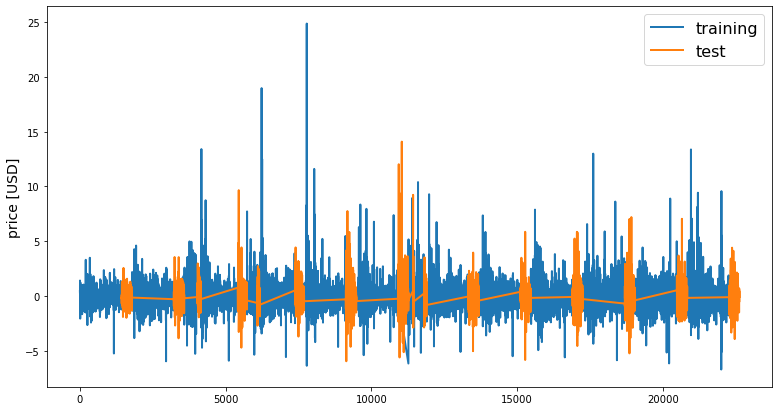

In [8]:
for coin in coins:
    
    